In [2]:
from micromind import MicroMind, Metric
from micromind.networks import PhiNet
from micromind.utils.parse import parse_arguments

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torchinfo import summary

In [3]:
classes = [    "apple",
    "aquarium_fish",
    "baby",
    "bear",
    "beaver",
    "bed",
    "bee",
    "beetle",
    "bicycle",
    "bottle",
    "bowl",
    "boy",
    "bridge",
    "bus",
    "butterfly",
    "camel",
    "can",
    "castle",
    "caterpillar",
    "cattle",
    "chair",
    "chimpanzee",
    "clock",
    "cloud",
    "cockroach",
    "couch",
    "crab",
    "crocodile",
    "cup",
    "dinosaur",
    "dolphin",
    "elephant",
    "flatfish",
    "forest",
    "fox",
    "girl",
    "hamster",
    "house",
    "kangaroo",
    "keyboard",
    "lamp",
    "lawn_mower",
    "leopard",
    "lion",
    "lizard",
    "lobster",
    "man",
    "maple_tree",
    "motorcycle",
    "mountain",
    "mouse",
    "mushroom",
    "oak_tree",
    "orange",
    "orchid",
    "otter",
    "palm_tree",
    "pear",
    "pickup_truck",
    "pine_tree",
    "plain",
    "plate",
    "poppy",
    "porcupine",
    "possum",
    "rabbit",
    "raccoon",
    "ray",
    "road",
    "rocket",
    "rose",
    "sea",
    "seal",
    "shark",
    "shrew",
    "skunk",
    "skyscraper",
    "snail",
    "snake",
    "spider",
    "squirrel",
    "streetcar",
    "sunflower",
    "sweet_pepper",
    "table",
    "tank",
    "telephone",
    "television",
    "tiger",
    "tractor",
    "train",
    "trout",
    "tulip",
    "turtle",
    "wardrobe",
    "whale",
    "willow_tree",
    "wolf",
    "woman",
    "worm"]

In [4]:
batch_size = 128

transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

trainset = torchvision.datasets.CIFAR100(
    root="data/cifar-100", train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=1
)

testset = torchvision.datasets.CIFAR100(
        root="data/cifar-100", train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=batch_size, shuffle=False, num_workers=1
)

Files already downloaded and verified
Files already downloaded and verified


/tmp/ipykernel_1212782/3705038873.py:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  plt.imshow(img.T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the 

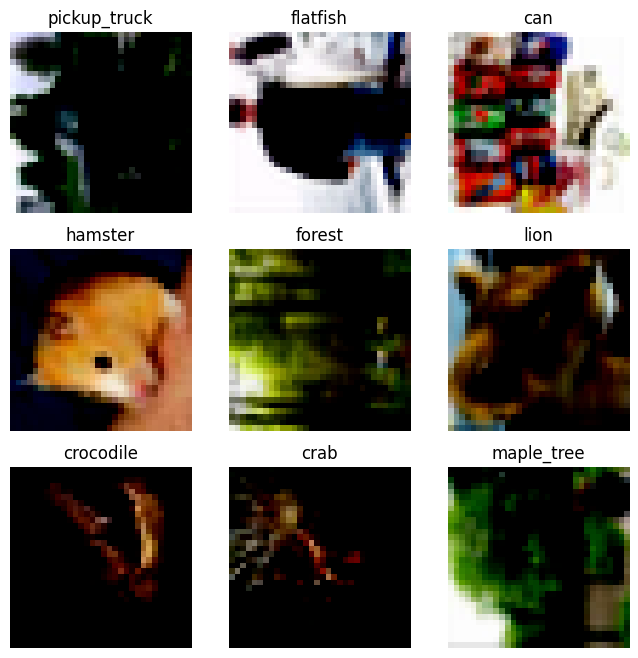

In [5]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(testset), size=(1,)).item()
    img, label = testset[sample_idx]
    figure.add_subplot(rows, cols, i)    
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(img.T)
plt.show()


In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
elif torch.backends.mps.is_available: 
    device = torch.device("mps")
    print("Running on the MPS")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
class ImageClassification(MicroMind):

    # test 1 with n as input vector size and m classes custom d
    # n has to be calculated from the output of the neural network of the feature extractor

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.modules["feature_extractor"] = PhiNet(
            (3, 32, 32), include_top=True, num_classes=100, alpha=3
        )        
                
        self.modules["feature_extractor"].load_state_dict(torch.load("./pretrained/a3_baseline.ckpt", map_location=device)["feature_extractor"])

    def forward(self, batch):
        return self.modules["feature_extractor"](batch[0])

    def compute_loss(self, pred, batch):
        return nn.CrossEntropyLoss()(pred, batch[1])


In [8]:
import argparse

def parse_test():
    parser = argparse.ArgumentParser(description="General configuration for micromind.")

    parser.add_argument("--lr", type=float, default=0.001, help="Learning rate.")
    parser.add_argument(
        "--optimizer",
        dest="opt",
        default="adam",
        choices=["adam", "sgd"],
        help="Optimizer name.",
    )
    parser.add_argument(
        "--experiment_name", default="exp", help="Name of the experiment."
    )
    parser.add_argument(
        "--output_folder", default="results", help="Output folder path."
    )
    parser.add_argument(
        "--debug",
        action="store_true",
        help="Run in debug mode to check train and validation steps.",
    )
    parser.add_argument(
        '--d', 
        type=int
    )

    args = parser.parse_args("")
    return args

In [9]:
# This is used ONLY if you are not using argparse to get the hparams
hparams = parse_test()

m = ImageClassification(hparams)


In [65]:
def compute_accuracy(pred, batch):
        tmp = (pred.argmax(1) == batch[1]).float()
        return tmp


acc = Metric(name="accuracy", fn=compute_accuracy)

m.train(
    epochs=1,
    datasets={"train": trainloader, "val": testloader, "test": testloader},
    metrics=[acc],
    debug=hparams.debug,
)

m.test(
    datasets={"test": testloader},
)

2023-10-29 11:13:16.637 | INFO     | micromind.core:on_train_start:331 - Loaded existing checkpoint from results/exp/save/epoch_0_val_loss_0.6145.ckpt.
2023-10-29 11:13:16.641 | INFO     | micromind.core:train:407 - Starting from epoch 1. Training is scheduled for 1 epochs.


Set device to  cuda


Testing...: 100%|##########| 79/79 [00:02<00:00, 31.99batches/s, loss=0.615]
2023-10-29 11:13:19.115 | INFO     | micromind.core:test:559 - Testing test_accuracy: 0.83 - test_loss: 0.61; 


'Testing test_accuracy: 0.83 - test_loss: 0.61; '

In [33]:
train_features, train_labels = next(iter(trainloader))
print(train_features.shape)

torch.Size([128, 3, 32, 32])


In [ ]:
sample_idx = torch.tensor([torch.randint(len(testset), size=(1,)).item() for x in range(128)])

imgs = torch.index_select(torch.tensor(testset.data), 0, sample_idx)
imgs = imgs / 255.0

labels = torch.index_select(torch.tensor(testset.targets), 0 , sample_idx)
print(labels)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


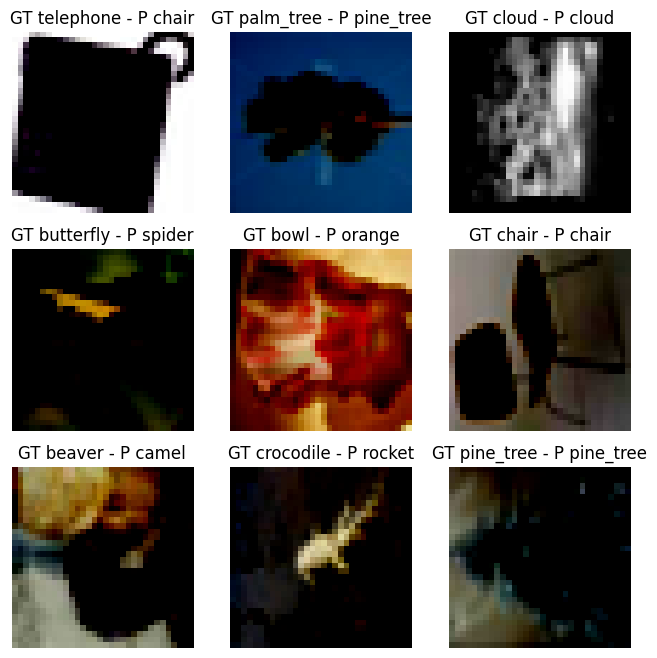

tensor(0.1797)


In [75]:

train_features, train_labels = next(iter(trainloader))

res = m.modules["feature_extractor"](train_features.to(device))

pred = torch.argmax(res, dim=1)
#print("predicted",  pred)
#print("GT", train_labels)

equal = pred.to('cpu') == train_labels

accuracy = sum(equal)/len(equal)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):   
    figure.add_subplot(rows, cols, i)    
    plt.title("GT " + classes[train_labels[i]] + " - P " + classes[pred[i]] )
    plt.axis("off")
    plt.imshow(train_features[i].T)
plt.show()

print(accuracy)
